In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
from torch.utils.tensorboard import SummaryWriter

## Generate Data

In [3]:
true_b = 1
true_w = 2
N = 100

In [4]:
np.random.seed(42)
X = np.random.rand(N, 1)
epsilon = (0.1 * np.random.randn(N, 1))
y = true_w * X + true_b + epsilon

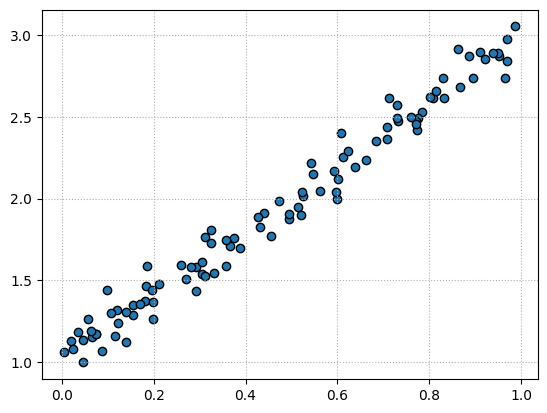

In [5]:
fig, ax = plt.subplots()
ax.scatter(X, y, edgecolor='k')
ax.grid(True, linestyle=':')
plt.show()

In [6]:
# Train Validation Split

In [7]:
idx = np.arange(N)
np.random.shuffle(idx)

train_idx = idx[:int(N * 0.8)]
val_idx = idx[int(N * 0.8):]

In [8]:
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

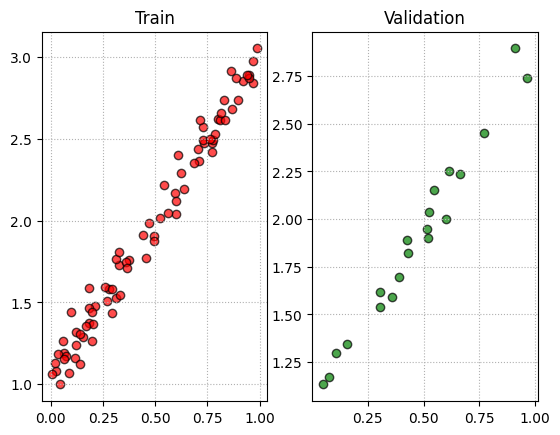

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X_train, y_train, edgecolor='k', c='r', alpha=.7)
ax1.grid(True, linestyle=':')
ax1.set_title('Train')

ax2.scatter(X_val, y_val, edgecolor='k', c='g', alpha=.7)
ax2.grid(True, linestyle=':')
ax2.set_title('Validation')
plt.show()

In [10]:
# Inicializando w e b aleatorios

In [11]:
np.random.seed(42)
w = np.random.randn(1)
b = np.random.randn(1)

print(w, b)

[0.49671415] [-0.1382643]


In [12]:
y_hat =  b + w * X_train

In [13]:
idx_sort = np.argsort(X_train[:, 0])

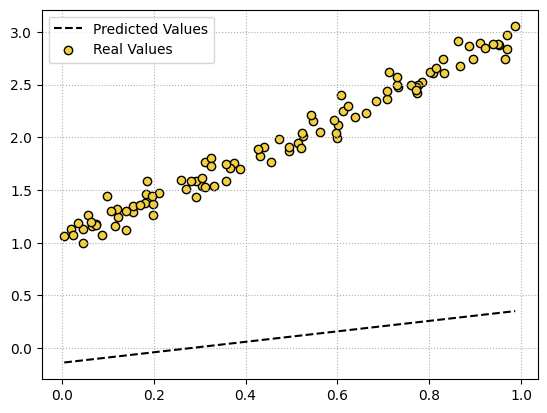

In [14]:
fig, ax = plt.subplots()
ax.plot(
    X_train[idx_sort],
    y_hat[idx_sort], 
    linestyle='--', 
    c='k',
    label='Predicted Values'
)
ax.scatter(
    X, 
    y, 
    c='#f4d03f', 
    edgecolor='k', 
    label='Real Values'
)
ax.grid(True, linestyle=':')
plt.legend()
plt.show()

# Correct way to create tensors with requires_grad

In [15]:
import torch

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

In [18]:
b

tensor([0.5623], device='cuda:0', requires_grad=True)

# Autograd
*Autograd* is Pytorch's automatic differentiation package. We **don't need to worry** about *partial derivatives, chain rule, or anything* like it.
**backward()** method compute gradients for all (gradient-requiring) tensor involved in the computation of a given variable.

In [19]:
X_train_tensor = torch.as_tensor(X_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [20]:
y_hat = w * X_train_tensor + b

In [21]:
error = (y_hat - y_train_tensor)
loss = (error ** 2).mean()

In [22]:
loss

tensor(1.1472, device='cuda:0', grad_fn=<MeanBackward0>)

In [23]:
loss.backward()

In [24]:
print('Grad b:', b.grad)
print('Grad w:', w.grad)

Grad b: tensor([-2.0140], device='cuda:0')
Grad w: tensor([-1.1682], device='cuda:0')


In [25]:
# O Gradiente acumula e agora o grad é exatamente o dobro:
# 2x
y_hat = w * X_train_tensor + b
error = (y_hat - y_train_tensor)
loss = (error ** 2).mean()
loss.backward()

print('Grad b:', b.grad)
print('Grad w:', w.grad)

Grad b: tensor([-4.0280], device='cuda:0')
Grad w: tensor([-2.3363], device='cuda:0')


<span style="color:red"><strong>IMPORTANTE:</strong></span> Se um tensor é usado para calcular outro ele será incluido na lista de diferenciação, capturar essas dependencias é exatamente o que a **dynamic computation graph** faz.

In [26]:
print(f'{error.requires_grad=}')
print(f'{y_hat.requires_grad=}')
print(f'{b.requires_grad=}')
print(f'{w.requires_grad=}')

error.requires_grad=True
y_hat.requires_grad=True
b.requires_grad=True
w.requires_grad=True


In [27]:
print(f'{y_train_tensor.requires_grad=}')  # backward não se importa com ele
print(f'{X_train_tensor.requires_grad=}')  # backward não se importa com ele

y_train_tensor.requires_grad=False
X_train_tensor.requires_grad=False


<span style="color:red"><strong>IMPORTANTE:</strong></span> O **Pytorch** acumula gradientes, e isso pode ser usado aqui. Quando sua maquina não é tão boa ele pode pegar o seu *mini-batch* e fazer dele *sub mini-batchs* pois ele não pode (consegue) jogar tudo de uma vez na memoria, por isso ele vai acumulando o gradiente para depois utilizar. Ele parcela o *mini-batch* basicamente.

We need to **zero the gradients afterward**. And that's what *zero_()* is good for. This resets the gradient.

In [28]:
b.grad.zero_(), w.grad.zero_()

(tensor([0.], device='cuda:0'), tensor([0.], device='cuda:0'))

In [29]:
# update
lr = 0.1
SEED = 42
EPOCHS = 1000

torch.manual_seed(SEED)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(EPOCHS):
    # forward pass
    y_hat = b + w * X_train_tensor

    # calculate the loss
    error = (y_hat - y_train_tensor)
    loss = (error ** 2).mean()

    # computes gradients for both 'b' and 'w'
    loss.backward()

    # updating the parameters
    # torch.no_grad() nos permite realizaar operações regulares sem afetar o gráfico de computação do Pytorch
    # Não se atualiza sem torch.no_grad()
    with torch.no_grad():
        b -= lr * b.grad
        w -= lr * w.grad

    b.grad.zero_()
    w.grad.zero_()

In [30]:
print(b)
print(w)

tensor([1.0235], device='cuda:0', requires_grad=True)
tensor([1.9690], device='cuda:0', requires_grad=True)


In [31]:
y_hat = b + w * X_train_tensor

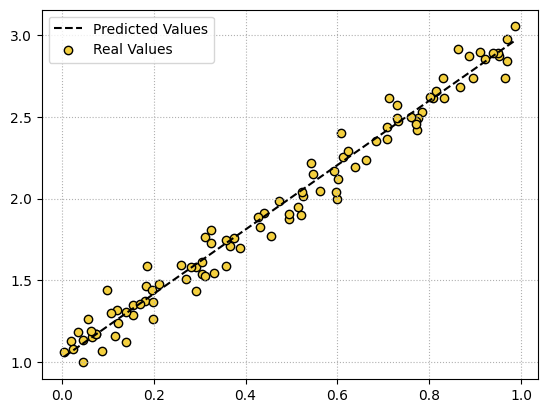

In [32]:
fig, ax = plt.subplots()
ax.plot(
    X_train_tensor[idx_sort].cpu().numpy(),
    y_hat[idx_sort].cpu().detach().numpy(),
    linestyle='--', 
    c='k',
    label='Predicted Values'
)
ax.scatter(
    X, 
    y, 
    c='#f4d03f', 
    edgecolor='k', 
    label='Real Values'
)
ax.grid(True, linestyle=':')
plt.legend()
plt.show()

Dynamic Computation Graph:


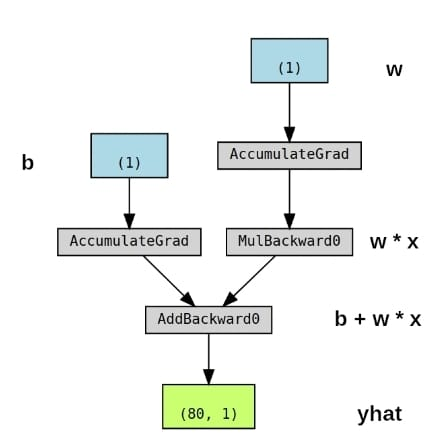

Why don't we have a box for our *data (X)*?  
R: We do not compute gradients for it!

# Optimizer
## step / zero_grad
Um `optimizer` pega os parâmetros que queremos atualizar, a taxa de aprendizado (lr) e executa as atualizações por meio do método **step()**.

In [33]:
optimizer = torch.optim.SGD([b, w], lr=lr)

Não será preciso zerar os gradientes um a um basta utilizar o método **zero_grad()**

In [34]:
lr = 0.1
SEED = 42

torch.manual_seed(SEED)

b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

optimizer = torch.optim.SGD([b, w], lr=lr)

EPOCHS = 1000

for epoch in range(EPOCHS):
    y_hat = b + w * X_train_tensor

    error = (y_hat - y_train_tensor)

    loss = (error ** 2).mean()

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


# Loss

In [35]:
import torch.nn as nn

In [36]:
criterion = nn.MSELoss(reduction='mean')  # HOF (High Order Function)
preds = torch.tensor([0.5, 1.0])
labels = torch.tensor([2.0, 1.3])
criterion(preds, labels)

tensor(1.1700)

In [37]:
lr = 0.1
SEED = 42

torch.manual_seed(SEED)

b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

optimizer = torch.optim.SGD([b, w], lr=lr)
criterion = nn.MSELoss(reduction='mean')

EPOCHS = 1000

for epoch in range(EPOCHS):
    y_hat = b + w * X_train_tensor

    loss = criterion(y_hat, y_train_tensor)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

print(b, w)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


In [38]:
loss

tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

Para transformar a `loss`, ou qualquer outro tensor que tem `requires_grad=True` em numpy, precisamos remover o calculo do gradiente utilizando `detach`.

In [39]:
loss.detach().cpu().numpy()

array(0.00804466, dtype=float32)

In [40]:
print(loss.item(), type(loss.item()))

0.008044655434787273 <class 'float'>


# Model

In [41]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.b = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float)
        )
        self.w = nn.Parameter(
            torch.randn(1, requires_grad=True, dtype=torch.float)
        )

    def forward(self, x):
        return self.b + self.w * x

In [42]:
torch.manual_seed(SEED)
dummy = ManualLinearRegression()
list(dummy.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [43]:
dummy.state_dict()

OrderedDict([('b', tensor([0.3367])), ('w', tensor([0.1288]))])

In [44]:
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1]}]}

In [45]:
lr = 0.1
SEED = 42

torch.manual_seed(SEED)

model = ManualLinearRegression().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='mean')

EPOCHS = 1000

for epoch in range(EPOCHS):
    model.train()
    y_hat = model(X_train_tensor)

    loss = criterion(y_hat, y_train_tensor)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('b', tensor([1.0235], device='cuda:0')), ('w', tensor([1.9690], device='cuda:0'))])


`model.train()` define o modelo para o modo de treinamento, alguns mecanismos funcionam diferentes durante o *treinamento* e *inferencia*, por exemplo o **Dropout**.

In [46]:
class MyLinearREgression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

In [47]:
torch.manual_seed(SEED)

model = nn.Sequential(nn.Linear(1, 1)).to(device)
model.state_dict()

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')),
             ('0.bias', tensor([0.8300], device='cuda:0'))])

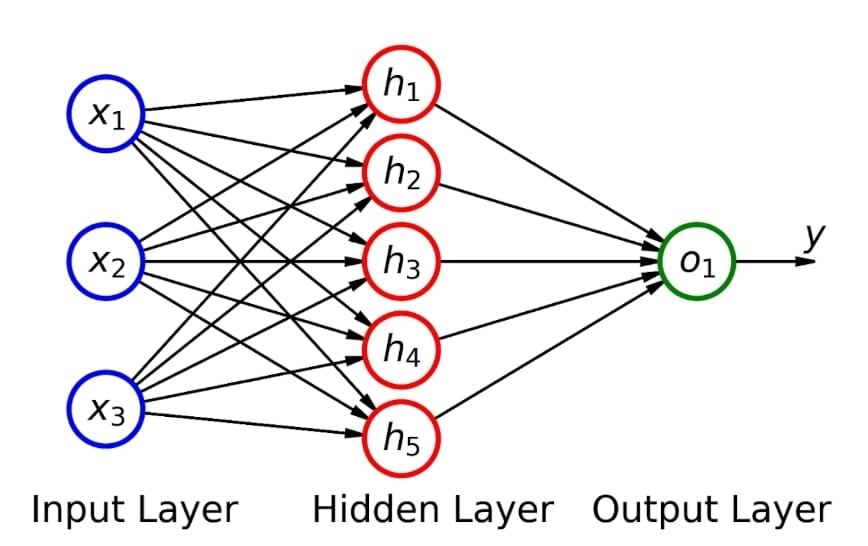

In [48]:
torch.manual_seed(SEED)

model = nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 1)).to(device)
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4414,  0.4792, -0.1353],
                      [ 0.5304, -0.1265,  0.1165],
                      [-0.2811,  0.3391,  0.5090],
                      [-0.4236,  0.5018,  0.1081],
                      [ 0.4266,  0.0782,  0.2784]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0815,  0.4451,  0.0853, -0.2695,  0.1472], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2060, -0.0524, -0.1816,  0.2967, -0.3530]], device='cuda:0')),
             ('1.bias', tensor([-0.2062], device='cuda:0'))])

In [49]:
torch.manual_seed(SEED)

model = nn.Sequential()
model.add_module('layer_1', nn.Linear(3, 5))
model.add_module('layer_2', nn.Linear(5, 1))
model.to(device)

Sequential(
  (layer_1): Linear(in_features=3, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

Existem muitas camadas que podem ser usadas no Pytorch:

- Convolution Layers
- Pooling Layers
- Padding Layers
- Non-linear Activations
- Normalization Layers
- Recurrent Layers
- Transformer Layers
- Linear Layers
- Dropout Layers
- Sparse Layers (embeddings)
- Vision Layers
- DataParallel Layers (multi-GPU)
- Flatten Layer

In [50]:
%%writefile data_preparation/v0.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train_tensor = torch.as_tensor(X_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

Overwriting data_preparation/v0.py


In [51]:
%run -i data_preparation/v0.py

Separe seu `pipeline` assim:

- Data Preparation
- Model Configuration
- Model Training

# Going Modular Training Step

In [52]:
from typing import Callable
from torch import Tensor

In [53]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [54]:
def make_train_step_fn(
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: torch.optim
) -> Callable[[Tensor, Tensor], float]:
    def train_step_fn(X: Tensor, y: Tensor) -> float:
        model.train()

        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()
    return train_step_fn

In [55]:
LR = 1e-2
model = ManualLinearRegression().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = nn.MSELoss(reduction='mean')

In [56]:
train_step_fn = make_train_step_fn(model=model, loss_fn=criterion, optimizer=optimizer)

In [57]:
train_step_fn

<function __main__.make_train_step_fn.<locals>.train_step_fn(X: torch.Tensor, y: torch.Tensor) -> float>

# Dataset

Para implementar um Dataset você necessita de 3 métodos fundamentais:
- `__init__`: Aqui é colocado tudo que você precisa para criação do Dataset;
- `__getitem__`: Deve retornar uma tupla (features, label) correspondente ao ponto de dados solicitado;
- `__len__`: Retorna o tamanho do dataset inteiro, quantas amostras ele possui.

In [58]:
from torch.utils.data import (
    Dataset,
    DataLoader,
    TensorDataset
)

class CustomDataset(Dataset):
    # não colocamos para ir para a gpu aqui pois vai ocupar memoria 
    def __init__(self, x_tensor: Tensor, y_tensor: Tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(self.x)

In [59]:
# neste exemplo ambos fazem a mesma coisa
train_dataset_ = CustomDataset(X_train_tensor, y_train_tensor)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

In [60]:
train_dataset[0]

(tensor([0.7713], device='cuda:0'), tensor([2.4745], device='cuda:0'))

In [61]:
train_dataset_[0]

(tensor([0.7713], device='cuda:0'), tensor([2.4745], device='cuda:0'))

# TensorDataset
- Utilize quando seus dados já forem tensores e você apenas precisa os organizar como um `Dataset`, como no exemplo acima. Colocamos tudo isso como `Dataset` porque vamos utilizar `DataLoader`.

# DataLoader
- Utilizamos o `DataLoader` para dividir os dados em `mini-batch` e falar se queremos que ele embaralhe os dados ou não, embaralhar os dados pode melhorar na hora do gradient descent e apenas em alguns casos não usaremos ele, (time-series por exemplo, pois havera vazamento de dados). Já no conjunto de teste e validação não é preciso embaralhar os dados pois não calcularemos o gradient para essas amostras.
- Podemos usar o `DataLoader` para buscar mini-lotes que compensem classes desequilibradas através do `sampler`.

- It is typical to use **powers of two** for mini-batch sizes, like *16*, *32*, *64* or *124*, and *32* seems to be the choice of most people, **Yann LeCun** included.

In [62]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

In [63]:
def see_loader_fn(loader: DataLoader) -> tuple[Tensor, Tensor]:
    return next(iter(loader))

In [64]:
see_loader_fn(train_loader)

[tensor([[0.4561],
         [0.4722],
         [0.2588],
         [0.5979],
         [0.8948],
         [0.9507],
         [0.1409],
         [0.0581],
         [0.2809],
         [0.0206],
         [0.6376],
         [0.1997],
         [0.1818],
         [0.8662],
         [0.4402],
         [0.1705]], device='cuda:0'),
 tensor([[1.7706],
         [1.9857],
         [1.5967],
         [2.0407],
         [2.7393],
         [2.8715],
         [1.1211],
         [1.2640],
         [1.5846],
         [1.1327],
         [2.1930],
         [1.3651],
         [1.3734],
         [2.6805],
         [1.9105],
         [1.3585]], device='cuda:0')]

In [65]:
len(list(train_loader)[0][0])

16

In [66]:
def mini_batch_fn(device, data_loader, step_fn):
    mini_batch_losses = []
    for X_batch, y_batch in data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mini_batch_loss = step_fn(X_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)
    loss = np.mean(mini_batch_losses)
    return loss

In [67]:
EPOCHS = 200
losses = []

for epoch in range(EPOCHS):
    loss = mini_batch_fn(device, train_loader, train_step_fn)
    losses.append(loss)

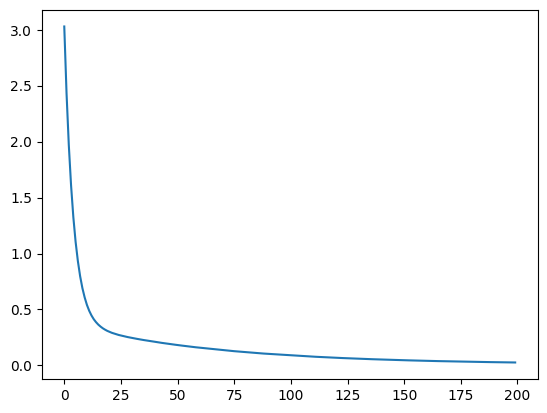

In [68]:
plt.plot(losses);

# random_split()
- Funciona como o `train_test_split` do sklearn.

In [69]:
from torch.utils.data import random_split
ratio = 0.8
eps = 1e-16
train_data, val_data = random_split(
    train_dataset,
    [ratio, 1 - ratio + eps]  # é preciso do eps por motivo de arredondamento
)

In [70]:
torch.manual_seed(SEED)
X_tensor = torch.as_tensor(X).float()
y_tensor = torch.as_tensor(y).float()

dataset = TensorDataset(X_tensor, y_tensor)

ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [71]:
LR = 0.1
model = ManualLinearRegression().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = nn.MSELoss(reduction='mean')

In [72]:
def make_val_step_fn(model, loss_fn):
    def perform_val_step_fn(X, y):
        model.eval()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        return loss.item()
    return perform_val_step_fn

In [73]:
train_step_fn = make_train_step_fn(model=model, loss_fn=criterion, optimizer=optimizer)

In [74]:
val_step_fn = make_val_step_fn(model, criterion)

In [75]:
EPOCHS = 100

losses = []
val_losses = []

for epoch in range(EPOCHS):
    loss = mini_batch_fn(device, train_loader, train_step_fn)
    losses.append(loss)
    with torch.inference_mode():
        val_loss = mini_batch_fn(device, val_loader, val_step_fn)
        val_losses.append(val_loss)

In [76]:
print(model.state_dict())

OrderedDict([('b', tensor([1.0159], device='cuda:0')), ('w', tensor([1.9612], device='cuda:0'))])


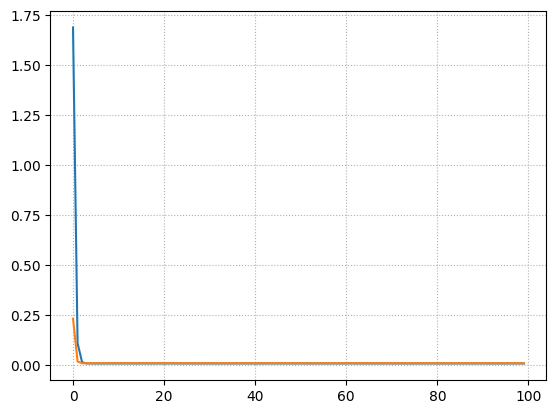

In [77]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.plot(val_losses)
ax.grid(True, linestyle=':')
plt.show()

# TensorBoard

In [108]:
writer = SummaryWriter('runs/simple_linear_regression')

In [109]:
# %%writefile data_preparation/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

LR = 0.1
torch.manual_seed(SEED)
model = nn.Sequential(
    nn.Linear(1, 1)
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)

criterion = nn.MSELoss(reduction='mean')

train_step_fn = make_train_step_fn(model, criterion, optimizer)

val_step_fn = make_val_step_fn(model, criterion)

dummy_X, dummy_y = see_loader_fn(train_loader)

writer.add_graph(model, dummy_X.to(device))

In [110]:
# %%writefile data_preparation/model_training.py
EPOCHS = 200

losses = []
val_losses = []

for epoch in range(EPOCHS):
    loss = mini_batch_fn(device, train_loader, train_step_fn)
    losses.append(loss)
    with torch.inference_mode():
        val_loss = mini_batch_fn(device, val_loader, val_step_fn)
        val_losses.append(val_loss)

    writer.add_scalars(
        main_tag='loss',
        tag_scalar_dict={
            'training': loss,
            'validation': val_loss
        },
        global_step=epoch
    )
writer.close()

# Saving and Loading Models
## Model State
- `model.state_dict()`
- `optimizer.state_dict()`
- `losses`: After all, you should keep track of its evolution;
- `epoch`
- `anything else you'd like to have restored later`.

In [111]:
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': losses,
    'val_loss': val_losses
}

In [112]:
# save model
MODEL_PATH = 'models/model_checkpoint.pth'
torch.save(checkpoint, MODEL_PATH)

In [113]:
checkpoint = torch.load(MODEL_PATH)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['loss']
saved_val_losses = checkpoint['val_loss']

In [114]:
model.train()

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [115]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9583]], device='cuda:0')), ('0.bias', tensor([1.0099], device='cuda:0'))])
